## Model 7: Siamese neural network ##

In this notebook, I further modify previously cropped images. See separate notebook for how I cropped the images to a bounding box around the whale's tail. 

Plan:


Note: affine transformation per Martin Piotte is not worth it. Simple Image.resize(x,y) does the same job nearly and is much simpler

In [1]:
# load libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import cv2
from operator import itemgetter # for sorting python lists

Using TensorFlow backend.


In [2]:
# find similar images
# using phash or average-hash

# this library needs to be installed:
# pip install ImageHash

import imagehash

In [3]:
# load data on training images
df1 = pd.read_csv('cropped_cleaned/traindf.csv')
print(df1.head())
print(len(df1))

           Image         Id  Processed  Attention
0  0000e88ab.jpg  w_f48451c          1          0
1  0001f9222.jpg  w_c3d896a          1          0
2  00029d126.jpg  w_20df2c5          1          0
3  000a6daec.jpg  w_dd88965          1          0
4  0016b897a.jpg  w_64404ac          1          0
15697


In [4]:
# remove problem images
df2 = df1[df1.Attention==0].copy()
df2.reset_index(drop=True, inplace=True)
print(df2.head())
print(len(df2))

           Image         Id  Processed  Attention
0  0000e88ab.jpg  w_f48451c          1          0
1  0001f9222.jpg  w_c3d896a          1          0
2  00029d126.jpg  w_20df2c5          1          0
3  000a6daec.jpg  w_dd88965          1          0
4  0016b897a.jpg  w_64404ac          1          0
15247


In [5]:
# create dataframe with distinct ids and count of images per id
ids = pd.DataFrame(df2['Id'].unique(), columns=['Id'])
ids['Count'] = 0
for r in ids.itertuples():
    id = r.Id
    cnt = len(df2[df2['Id'] == id])
    ind = ids[ids['Id'] == id].index.values[0]
    ids.loc[ind, 'Count'] = cnt
print(ids.head())
print(len(ids))

          Id  Count
0  w_f48451c     14
1  w_c3d896a      4
2  w_20df2c5      4
3  w_dd88965     16
4  w_64404ac      5
4968


In [6]:
# remove images that are the only example of their label
df3 = df2.copy()
toremove = ids[ids.Count==1].copy()
for id in toremove.Id:
    ind = df3[df3.Id==id].index.tolist()
    df3.drop(ind, inplace=True)
df3.reset_index(drop=True, inplace=True)
print(df3.head())
print(len(df3))

           Image         Id  Processed  Attention
0  0000e88ab.jpg  w_f48451c          1          0
1  0001f9222.jpg  w_c3d896a          1          0
2  00029d126.jpg  w_20df2c5          1          0
3  000a6daec.jpg  w_dd88965          1          0
4  0016b897a.jpg  w_64404ac          1          0
13134


In [7]:
# compute phash for each remaining image
df3['Hash'] = 0
i = 0
for img in df3.Image:
    img = 'cropped_cleaned/train/' + img
    img = Image.open(img)
    # h = imagehash.average_hash(img)
    h = imagehash.phash(img)
    df3.at[i,'Hash'] = h
    i += 1
# drop columns Processed and Attention - we don't need them any more
df3.drop(['Processed', 'Attention'], axis=1, inplace=True)
print(df3.head())
print(len(df3))

           Image         Id              Hash
0  0000e88ab.jpg  w_f48451c  f01ddaf6d2340770
1  0001f9222.jpg  w_c3d896a  bacec2b7e888c703
2  00029d126.jpg  w_20df2c5  bfcad234a5290f0b
3  000a6daec.jpg  w_dd88965  e91b8cc2f2707279
4  0016b897a.jpg  w_64404ac  e99a8624bfe19836
13134


## Training Set ##

Now, let's create maybe 4 sets of image pairs, 
200 pairs in each set: 100 same-label pairs and 100 diff-label pairs

Use 3 of them for training and 1 for validation

The difference across the 4 sets will be in the difficulty of the diff-label pairs:

- in the 1st set, the difficulty will be easy (pair images at random)
- in the 2nd set, the difficulty will be moderate (pair images where phash is somewhat different: 10-20 bit diff) 
- in the 3nd set, the difficulty will be high (pair images where phash is only slightly different: 0-10 bit diff) 
- in the 4th set (validation), probably moderately difficult (phash diff by 10-20 bits)

In [8]:
# Create pairs of same-label images

# get list of 400 ids at random
ids        = pd.DataFrame(df3['Id'].unique(), columns=['Id'])
ids_np     = np.array(ids.Id)
ids_np_400 = np.random.choice(ids_np, size=400, replace=False)

ps_same = []
for id in ids_np_400:
    imgs = df3[df3.Id==id]['Image'].tolist()
    imgs = imgs[:2]
    ps_same.append(imgs)

# check if all elements are size=2
i = 0
for l in ps_same:
    if len(l) != 2:
        # make sure every element is exactly 2 elements
        print('problem found at position {}'.format(i))
    i += 1

ps_same_1 = ps_same[   :100]  # for training
ps_same_2 = ps_same[100:200]  # for training
ps_same_3 = ps_same[200:300]  # for training
ps_same_4 = ps_same[300:   ]  # for validation

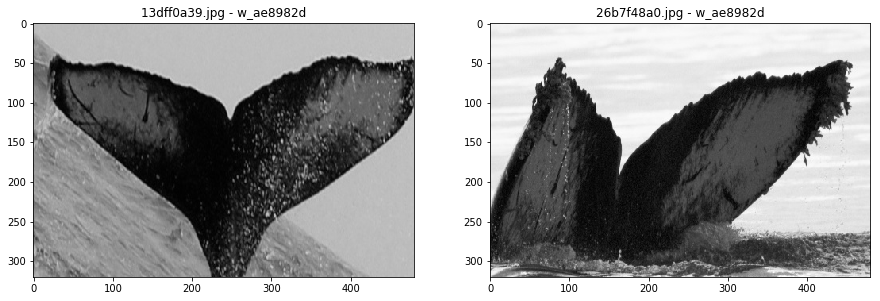

In [33]:
# look at a couple

def show_imgs(imgs):
    n       = len(imgs)
    y       = max(1, n//3) + (1 if (n//3>0 and n%3>0) else 0)
    x       = n if n<3 else 3
    fig, ax = plt.subplots(nrows=y, ncols=x, figsize=(15,y*5))
    labels  = [df3.loc[df3['Image']==im, ['Id']].values[0][0] for im in imgs]
    titles  = ['{} - {}'.format(a, b) for a, b in zip(imgs, labels)]
    path    = 'cropped_cleaned/train/'
    m       = 0
    for i in range(y):
        for j in range(x):
            if m >= n:
                break
            img = Image.open(path+imgs[m])
            if y==1:
                ax[j].imshow(img)
                ax[j].set(title=titles[m])
            else:
                ax[i,j].imshow(img)
                ax[i,j].set(title=titles[m])
            m += 1

imgs = ps_same_2[45]
show_imgs(imgs)

In [ ]:
# create pairs of diff-label images
# (re-using the images from the same-label set)

In [28]:
# Lets create sets 2, 3, 4 - these are not random

# first, build list of phash values 
hashes_same = []
for img1, img2 in ps_same:
    h1 = df3.loc[df3['Image']==img1, ['Hash']].values[0][0]
    h2 = df3.loc[df3['Image']==img2, ['Hash']].values[0][0]
    hashes_same.append([h1,h2])

# flatten ps_same
ps = [i[0] for i in ps_same] + [i[1] for i in ps_same]
# flatten hashes_same
hs = [i[0] for i in hashes_same] + [i[1] for i in hashes_same]
# zip them together
ps_hs = list(zip(ps, hs))

ps_diff_score = []

for i in range(400):
    last_diff = 64 # max difference possible
    candidate = ''
    p, h = ps_hs.pop(0)
    # find the pair image
    for i1, i2 in ps_same:
        if i1==p or i2==p:
            if i1==p:
                p_pair = i2
            else:
                p_pair = i1
            break
    ind = 0
    for p2, h2 in ps_hs:
        # skip if same image or its partner (same-label) image
        if p2==p_pair:
            ind += 1
            continue
        diff = abs(h-h2)
        if diff <= last_diff:
            candidate = p2
            last_diff = diff
            ind_to_pop = ind
        ind += 1
    if candidate:
        ps_diff_score.append([p, candidate, last_diff])
        ps_hs.pop(ind_to_pop)
    else:
        print('done')
        break

# sort so the least difficult (least similar) pairs appear first
ps_diff_score.sort(key=itemgetter(2), reverse=True)

print(len(ps_diff_score))

400


In [29]:
# explore the score (absolute phash difference)
steps = [0,99,199,299,399]
for i in steps:
    print('pair {:<3} has score {:<2}'.format(i, ps_diff_score[i][2]))

pair 0   has score 28
pair 99  has score 18
pair 199 has score 16
pair 299 has score 14
pair 399 has score 4 


In [ ]:
# The first group is the least difficult (least similar)
# The last group is the most difficult (most similar)

In [30]:
# remove score, it's not needed any longer
ps_diff = [[i[0], i[1]] for i in ps_diff_score]
# create sets
ps_diff_2 = ps_diff[200:300]  # for training
ps_diff_3 = ps_diff[300:400]  # for training
ps_diff_4 = ps_diff[100:200]  # for validation

In [31]:
# finally, create set 1 (random pairs) using the remaining images
ps_diff_rest = ps_diff[0:100]
ps_flat = [i[0] for i in ps_diff_rest] + [i[1] for i in ps_diff_rest]

ps_diff_1 = []
for i in range(100):
    while True:
        i1, i2 = random.sample(range(len(ps_flat)), 2)
        img1 = ps_flat[i1]
        img2 = ps_flat[i2]
        lab1 = df3.loc[df3['Image']==img1, ['Id']].values[0][0]
        lab2 = df3.loc[df3['Image']==img2, ['Id']].values[0][0]
        if lab1 != lab2:
            break
    i1, i2 = sorted([i1, i2])
    img2 = ps_flat.pop(i2)
    img1 = ps_flat.pop(i1)
    ps_diff_1.append([img1, img2])
    
print(len(ps_diff_1))

100


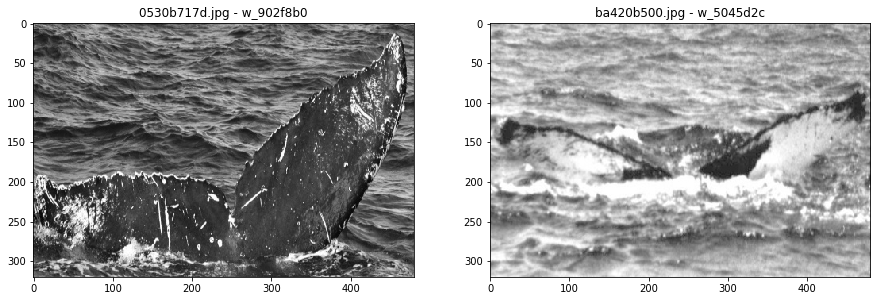

In [34]:
# look at a couple
imgs      = ps_diff_1[95]
show_imgs(imgs)

In [42]:
# check if any pair contains same-label images (none should)
for im1, im2 in ps_diff_1:
    label1 = df3.loc[df3['Image']==im1, ['Id']].values[0][0]
    label2 = df3.loc[df3['Image']==im2, ['Id']].values[0][0]
    if label1 == label2:
        print('STOP! Problem.')
        break
print('done')

all good


In [ ]:
# this is where I stopped. 
# training and validation sets are almost ready,
# tomorrow - mix them together by alternating same- diff- label pairs.

In [57]:
# check that each of 800 images shows up exactly twice
flat  = []
lists = [ps_same_1,ps_diff_1,ps_same_2,ps_diff_2,ps_same_3,ps_diff_3,ps_same_4,ps_diff_4]
for l in lists:
    flat += [i[0] for i in l] + [i[1] for i in l]
imgs_unique = set(flat)
for i in imgs_unique:
    count = 0
    for j in flat:
        if i==j:
            count += 1
    if count != 2:
        print('STOP! Problem.')
        break
print('done')

All good


In [118]:
def makeset(set1, set2):
    '''
    Zip elements of two sets by alternating them:
    element 1 from set 1, element 1 from set 2, element 2 from set 1, etc.
    And create a target set, assuming set2 is the negative set (diff-label pairs)
    '''
    n = len(set1)
    if n != len(set2):
        print('Both sets need to be the same lenth')
        return
    pairs = []
    for i in range(n):
        pairs.append(set1[i])
        pairs.append(set2[i])
    return pairs

In [119]:
# zip the pairs by alternating them
train_1 = makeset(ps_same_1, ps_diff_1)
train_2 = makeset(ps_same_2, ps_diff_2)
train_3 = makeset(ps_same_3, ps_diff_3)
test    = makeset(ps_same_4, ps_diff_4)

In [120]:
# create targets
# note that all sets have the same alternating targets: 1, 0, 1, 0, etc.
# so, a single target set can be used for all training and testing sets
targets = np.zeros(200)
t = 0
for i in range(100):
    targets[t] = 1
    t += 2
print(len(targets))
targets[0:5]

200


array([1., 0., 1., 0., 1.])

In [78]:
# convert to dataframe and save to disk
traindf1 = pd.DataFrame(train_1, columns=['Image1','Image2'])
traindf2 = pd.DataFrame(train_2, columns=['Image1','Image2'])
traindf3 = pd.DataFrame(train_3, columns=['Image1','Image2'])
testdf    = pd.DataFrame(test,    columns=['Image1','Image2'])
# save to disk
traindf1.to_csv('cropped_cleaned/traindf1.csv', index=False)
traindf2.to_csv('cropped_cleaned/traindf2.csv', index=False)
traindf3.to_csv('cropped_cleaned/traindf3.csv', index=False)
testdf.to_csv('cropped_cleaned/testdf.csv', index=False)

# or load previously saved dataframe
# traindf1 = pd.read_csv('cropped_cleaned/traindf1.csv')
# traindf2 = pd.read_csv('cropped_cleaned/traindf2.csv')
# traindf3 = pd.read_csv('cropped_cleaned/traindf3.csv')
# testdf    = pd.read_csv('cropped_cleaned/testdf.csv')

In [131]:
# create dataframe of same-label pairs and save to disk
# use the first two sets
ps_same_12 = ps_same_1 + ps_same_2
traindfs = pd.DataFrame(ps_same_12, columns=['Image1','Image2'])
traindfs.to_csv('cropped_cleaned/traindfs.csv', index=False)

## Create Tensors ##

In [88]:
# function to convert image to tensor
def img_to_tensor(img, size=(320,480)):
    '''
    img: path to image file
    size: (height, width)
    '''
    HEIGHT, WIDTH = size
    tensor = np.zeros((HEIGHT, WIDTH))
    # load image to PIL format
    img = Image.open(img)
    # convert to numpy array/tensor with shape (HEIGHT, WIDTH, 1)
    x = image.img_to_array(img)
    # min-max normalize
    xmin   = np.min(x)
    xmax   = np.max(x)
    xrange = xmax-xmin
    x      = (x-xmin)/xrange
    return x

In [89]:
def maketensors(df):
    '''
    Create tensors for siamese network
    '''
    n = len(df)
    array1 = np.zeros((n, 320, 480, 1))
    array2 = np.zeros((n, 320, 480, 1))
    path = 'cropped_cleaned/train/'
    i = 0
    for r in df.itertuples():
        array1[i] = img_to_tensor(path+r.Image1)
        array2[i] = img_to_tensor(path+r.Image2)
        i += 1
    return [array1, array2]

In [98]:
# make tensors
traints1 = maketensors(traindf1)
traints2 = maketensors(traindf2)
traints3 = maketensors(traindf3)
testts = maketensors(testdf)

In [ ]:
# save tensors to disk

### Build Siamese Model ###

In [94]:
# load libraries
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

In [106]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

input_shape = (320,480,1)

input_1 = Input(input_shape)
input_2 = Input(input_shape)

# convolution network to be used in each siamese branch
model = Sequential()
model.add(Conv2D(filters=16, 
                 kernel_size=2,
                 padding='same',
                 activation='relu', 
                 input_shape=input_shape,
                 #kernel_initializer=initialize_weights,
                 kernel_regularizer=l2(0.0001) #2e-4
                ))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding='same',
                 activation='relu',
                 #kernel_initializer=initialize_weights,
                 #bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.0001) #2e-4
                ))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, 
                 kernel_size=2,
                 padding='same',
                 activation='relu', 
                 #kernel_initializer=initialize_weights,
                 #bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.0001) #2e-4
                ))
model.add(Flatten())
model.add(Dense(200,
                activation='sigmoid',
                #kernel_initializer=initialize_weights,
                #bias_initializer=initialize_bias,
                kernel_regularizer=l2(0.001) #1e-3
               ))

# Generate the encodings (feature vectors) for the two images
encoded_1 = model(input_1)
encoded_2 = model(input_2)

distance = Lambda(euclidean_distance,
output_shape=eucl_dist_output_shape)([encoded_1, encoded_2])

# Add a customized layer to compute the absolute difference between the encodings
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
# L1_distance = L1_layer([encoded_1, encoded_2])

# Add a dense layer with a sigmoid unit to generate the similarity score
# prediction = Dense(1,activation='sigmoid')(L1_distance)
# prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(distance)
prediction = Dense(1,activation='sigmoid')(distance)

# Connect the inputs with the outputs
siamese_model = Model(inputs=[input_1, input_2], outputs=prediction)

# Compile, summarize
siamese_model.compile(loss='binary_crossentropy',optimizer=Adam())
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 200)          122890616   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           sequential_3[1][0]               
          

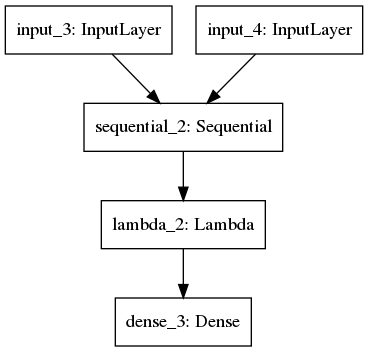

In [97]:
# plot model diagram
from keras.utils import plot_model
plot_model(siamese_model, to_file='model.png')
img = Image.open('model.png')
display(img)

In [123]:
# train the model
EPOCHS = 1
BATCH_SIZE = 4
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.model_1.h5', verbose=1, save_best_only=True)
history = siamese_model.fit(
        x=traints1,
        y=train_targets_1,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        #callbacks=[checkpointer],
        #validation_split=0.1,
        verbose=1)

Epoch 1/1
200/200 [==============================] - 80s 400ms/step - loss: 1.1508


### Nest steps continue in Kaggle kernel ###
------------------------------------------------
From this point I used a Kaggle kernel with a GPU to train and experiment with model parameters.


In [100]:
def score(predictions, targets):
    '''
    Compute accuracy
    '''
    n = len(targets)
    if len(predictions) != n:
        print('The two lists must be the same length.')
        return
    i = 0
    s = []
    for p in predictions:
        p = p[0]
        p = 1.0 if p>0.5 else 0.0
        t = targets[i]
        if p==t:
            s.append(1)
        else:
            s.append(0)
        i += 1
    return sum(s)/n

In [124]:
preds = siamese_model.predict(testts)
score(preds, test_targets)

0.515

In [125]:
print(preds)

[[0.4962488 ]
 [0.4965937 ]
 [0.4969661 ]
 [0.4969913 ]
 [0.50847906]
 [0.49536583]
 [0.49403718]
 [0.49651483]
 [0.4958533 ]
 [0.49473274]
 [0.5023614 ]
 [0.5049418 ]
 [0.4966891 ]
 [0.49592623]
 [0.4989439 ]
 [0.4973277 ]
 [0.49728417]
 [0.497542  ]
 [0.5115514 ]
 [0.51307636]
 [0.49557278]
 [0.49614444]
 [0.50584966]
 [0.49505267]
 [0.4988587 ]
 [0.4990624 ]
 [0.49772   ]
 [0.5025708 ]
 [0.50043195]
 [0.49777725]
 [0.49800456]
 [0.5009465 ]
 [0.49590352]
 [0.50344723]
 [0.50088984]
 [0.49808878]
 [0.49973395]
 [0.4943487 ]
 [0.4952906 ]
 [0.49695358]
 [0.4971766 ]
 [0.5160647 ]
 [0.49461985]
 [0.49765807]
 [0.49496093]
 [0.49858162]
 [0.50145525]
 [0.49904186]
 [0.5026549 ]
 [0.49995065]
 [0.4948664 ]
 [0.49746448]
 [0.49428508]
 [0.4946661 ]
 [0.4990571 ]
 [0.4989712 ]
 [0.5035724 ]
 [0.4947105 ]
 [0.4959323 ]
 [0.49687102]
 [0.49534547]
 [0.50919217]
 [0.50352645]
 [0.49858424]
 [0.4972347 ]
 [0.49410364]
 [0.49432126]
 [0.49719402]
 [0.49556857]
 [0.49440253]
 [0.50013906]
 [0.49

In [112]:
train_targets_1[0:5]

array([0., 1., 0., 1., 0.])

### Old stuff below this point ###

In [8]:
# find similar images
# where "similar" means hash values are different by no more than [limit] bits
limit = 7
hs = np.array(df3[['Image','Hash']]).tolist()
ps = []
i = 0
while True:
    h = []
    p = []
    try:
        n = hs.pop()
        i += 1
        ni,nh = n
        for c in hs:
            _,ch = c
            if (ch-nh) <= limit:
                h.append(c)
                i += 1
        if h:
            for c in h:
                ci,_ = c
                hs.remove(c)
                p.append(ci)
            p.append(ni)
            ps.append(p)
    except:
        break
print('Processed {} images'.format(i))
print('Found {} groups of similar images'.format(len(ps)))
# print(ps[0])

# how many similar images in total?
n = 0
pn = 0
for i in ps:
    ti = len(i)
    n += ti
    if ti > pn:
        pn = ti
print('For a total of {} similar images'.format(n))
print('Where the largest group has {} similar images'.format(pn))

Processed 13207 images
Found 581 groups of similar images
For a total of 1632 similar images
Where the largest group has 19 similar images


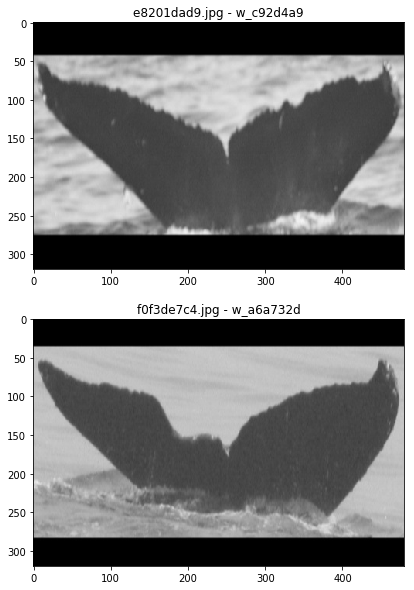

In [14]:
# let's look at one group of similar images
x = 1
imgs = ps[90]
y = len(imgs)
fig, ax = plt.subplots(y, x, figsize=(30,y*5))

for i in range(y):
    fnam = imgs[i]
    label = df3.loc[df3['Image']==fnam, ['Id']].values[0][0]
    title = '{} - {}'.format(fnam, label)
    img_path = 'cropped_cleaned/train/' + fnam
    img = Image.open(img_path)
    ax[i].imshow(img)
    ax[i].set(title=title)

In [15]:
# do any belong to the same label?
# those need to be removed/ignored
res = []
i = 0
for l in ps:
    labels = []
    for p in l:
        label = df3.loc[df3['Image']==p, ['Id']].values[0][0]
        if label in labels:
            res.append(i)
        labels.append(label)
    i += 1
print(res)

[7, 7, 12, 50, 53, 63, 108, 132, 148, 161, 241, 258, 342, 342, 368, 406, 412, 441, 512, 556, 566]


In [16]:
# remove those images from the list of similars
for i in res[::-1]:
    del ps[i]

# and compute stats
n = 0
pn = 0
for i in ps:
    ti = len(i)
    n += ti
    if ti > pn:
        pn = ti
print('{} groups of similar images left'.format(len(ps)))
print('For a total of {} similar images'.format(n))
print('Where the largest group has {} similar images'.format(pn))

560 groups of similar images left
For a total of 1530 similar images
Where the largest group has 19 similar images


In [17]:
# 1 of 2: create list of 500 image pairs
# for images that belong to different labels
ps_diff = []
i = 0
for l in ps:
    if i==500:
        break
    l = l[:2]
    ps_diff.append(l)
    i += 1

print('first 3 pairs:')
print(ps_diff[:3])
print(len(ps_diff))

first 3 pairs:
[['4cb90f820.jpg', 'ffa5fa27e.jpg'], ['78f190f6c.jpg', '935851f78.jpg'], ['73cd730e8.jpg', 'ff6e12f04.jpg']]
500


In [18]:
# convert to dataframe and save to disk
# df_diff = pd.DataFrame(ps_diff, columns=['Image1','Image2'])
# df_diff.to_csv('cropped_cleaned/dfdiff.csv', index=False)

# or load previously saved dataframe
df_diff = pd.read_csv('cropped_cleaned/dfdiff.csv')

print(df_diff.head())
len(df_diff)

          Image1         Image2
0  4cb90f820.jpg  ffa5fa27e.jpg
1  78f190f6c.jpg  935851f78.jpg
2  73cd730e8.jpg  ff6e12f04.jpg
3  4ab9d233c.jpg  55feede27.jpg
4  f31817534.jpg  ff31cf802.jpg


500

[Text(0.5, 1.0, '69604c947.jpg - w_1ff168e')]

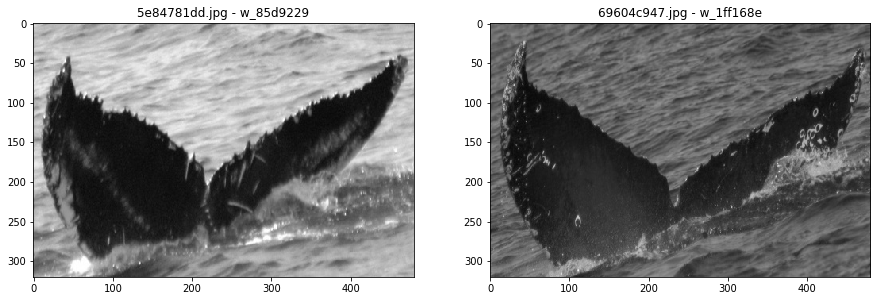

In [19]:
# look at a couple
imgs      = ps_diff[499]
fig, ax   = plt.subplots(1, 2, figsize=(15,10))
fnam1     = imgs[0]
fnam2     = imgs[1]
label1    = df3.loc[df3['Image']==fnam1, ['Id']].values[0][0]
label2    = df3.loc[df3['Image']==fnam2, ['Id']].values[0][0]
title1    = '{} - {}'.format(fnam1, label1)
title2    = '{} - {}'.format(fnam2, label2)
img1_path = 'cropped_cleaned/train/' + fnam1
img2_path = 'cropped_cleaned/train/' + fnam2
img1      = Image.open(img1_path)
img2      = Image.open(img2_path)
ax[0].imshow(img1)
ax[0].set(title=title1)
ax[1].imshow(img2)
ax[1].set(title=title2)

In [20]:
# 2 of 2: create list of 500 image pairs
# for images that belong to same labels

# get list of ids for remaining images
ids = pd.DataFrame(df3['Id'].unique(), columns=['Id'])

ps_same = []
i = 0
for id in ids.Id:
    if i==500:
        break
    imgs = df3[df3.Id==id]['Image'].tolist()
    imgs = imgs[:2]
    ps_same.append(imgs)
    i += 1

print('first 3 pairs:')
print(ps_same[:3])
len(ps_same)

first 3 pairs:
[['0000e88ab.jpg', '0af805558.jpg'], ['0001f9222.jpg', '1d6ccd05a.jpg'], ['00029d126.jpg', '94e15dfd2.jpg']]


500

In [21]:
# convert to dataframe and save to disk
# df_same = pd.DataFrame(ps_same, columns=['Image1','Image2'])
# df_same.to_csv('cropped_cleaned/dfsame.csv', index=False)

# or load previously saved dataframe
df_same = pd.read_csv('cropped_cleaned/dfsame.csv')

print(df_same.head())
len(df_same)

          Image1         Image2
0  0000e88ab.jpg  0af805558.jpg
1  0001f9222.jpg  1d6ccd05a.jpg
2  00029d126.jpg  94e15dfd2.jpg
3  000a6daec.jpg  01c602e06.jpg
4  0016b897a.jpg  50e0f92fa.jpg


500

[Text(0.5, 1.0, '5eacec601.jpg - w_b20b425')]

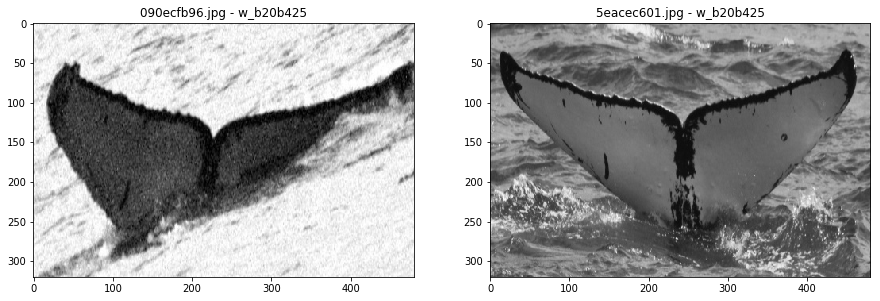

In [23]:
# look at a couple
imgs      = ps_same[404]
fig, ax   = plt.subplots(1, 2, figsize=(15,10))
fnam1     = imgs[0]
fnam2     = imgs[1]
label1    = df3.loc[df3['Image']==fnam1, ['Id']].values[0][0]
label2    = df3.loc[df3['Image']==fnam2, ['Id']].values[0][0]
title1    = '{} - {}'.format(fnam1, label1)
title2    = '{} - {}'.format(fnam2, label2)
img1_path = 'cropped_cleaned/train/' + fnam1
img2_path = 'cropped_cleaned/train/' + fnam2
img1      = Image.open(img1_path)
img2      = Image.open(img2_path)
ax[0].imshow(img1)
ax[0].set(title=title1)
ax[1].imshow(img2)
ax[1].set(title=title2)

In [ ]:
# for tomorrow:
# - research a simple siamese network architecture
#   and try to build one in keras
# - find out how the input images should be supplied - as a single tensor or double
# - find out how the labels/targets should look like
# - find out how the head of the model should look, the one that measures distance.

In [ ]:
# in researching siamese networks, this site seems most useful:
# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

In [24]:
# function to convert image to tensor
def img_to_tensor(img, size=(320,480)):
    '''
    img: path to image file
    size: (height, width)
    '''
    HEIGHT, WIDTH = size
    tensor = np.zeros((HEIGHT, WIDTH))
    # load image to PIL format
    img = Image.open(img)
    # convert to numpy array/tensor with shape (HEIGHT, WIDTH, 1)
    x = image.img_to_array(img)
    # min-max normalize
    xmin   = np.min(x)
    xmax   = np.max(x)
    xrange = xmax-xmin
    x      = (x-xmin)/xrange
    return x

In [69]:
# make train tensors
array1 = np.zeros((100, 320, 480, 1))
array2 = np.zeros((100, 320, 480, 1))
path = 'cropped_cleaned/train/'
i = 0
for r in df_same.itertuples():
    if i==50:
        break
    array1[i] = img_to_tensor(path+r.Image1)
    array2[i] = img_to_tensor(path+r.Image2)
    i += 1
for r in df_diff.itertuples():
    if i==100:
        break
    array1[i] = img_to_tensor(path+r.Image1)
    array2[i] = img_to_tensor(path+r.Image2)
    i += 1
tensors_train = [array1, array2]

In [70]:
# make train labels
# first 500 pairs are for same-label images, remaining 500 for diff-label images
tensors_train_labels = np.zeros(100)
tensors_train_labels[:50] = 1

In [27]:
# load libraries
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

In [35]:
# (skip for now)
# functions to initialize weights and bias

def initialize_weights(shape,name=None):
    """Initialize weights as in paper"""
    values = np.random.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def initialize_bias(shape,name=None):
    """Initialize bias as in paper"""
    values=np.random.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [63]:
# siamese model
# updated version

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

input_shape = (320,480,1)

input_1 = Input(input_shape)
input_2 = Input(input_shape)

# convolution network to be used in each siamese branch
model = Sequential()
model.add(Conv2D(filters=16, 
                 kernel_size=2,
                 padding='same',
                 activation='relu', 
                 input_shape=input_shape,
                 #kernel_initializer=initialize_weights,
                 #kernel_regularizer=l2(0.0001) #2e-4
                ))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding='same',
                 activation='relu',
                 #kernel_initializer=initialize_weights,
                 #bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.0001) #2e-4
                ))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, 
                 kernel_size=2,
                 padding='same',
                 activation='relu', 
                 #kernel_initializer=initialize_weights,
                 #bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.0001) #2e-4
                ))
model.add(Flatten())
model.add(Dense(100,
                activation='sigmoid',
                #kernel_initializer=initialize_weights,
                #bias_initializer=initialize_bias,
                kernel_regularizer=l2(0.001) #1e-3
               ))

# Generate the encodings (feature vectors) for the two images
encoded_1 = model(input_1)
encoded_2 = model(input_2)

distance = Lambda(euclidean_distance,
output_shape=eucl_dist_output_shape)([encoded_1, encoded_2])

# Add a customized layer to compute the absolute difference between the encodings
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
# L1_distance = L1_layer([encoded_1, encoded_2])

# Add a dense layer with a sigmoid unit to generate the similarity score
# prediction = Dense(1,activation='sigmoid')(L1_distance)
prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(distance)

# Connect the inputs with the outputs
siamese_model = Model(inputs=[input_1, input_2], outputs=prediction)

# Compile 
siamese_model.compile(loss='binary_crossentropy',optimizer=Adam())

siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 100)          61450516    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 1)            0           sequential_5[1][0]               
          

In [36]:
# siamese model
# I AM SURE I WILL GET IT WRONG IN THE BEGINNING, SO DON'T JUMP TO CONCLUSIONS!!!

input_shape = (320,480,1)

input_1 = Input(input_shape)
input_2 = Input(input_shape)

# convolution network to be used in each siamese branch
model = Sequential()
model.add(Conv2D(filters=16, 
                 kernel_size=2,
                 padding='same',
                 activation='relu', 
                 input_shape=input_shape,
                 kernel_initializer=initialize_weights,
                 kernel_regularizer=l2(6e-4) #2e-4
                ))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding='same',
                 activation='relu',
                 kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.001) #2e-4
                ))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, 
                 kernel_size=2,
                 padding='same',
                 activation='relu', 
                 kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.001) #2e-4
                ))
model.add(Flatten())
model.add(Dense(100,
                activation='sigmoid',
                kernel_initializer=initialize_weights,
                bias_initializer=initialize_bias,
                kernel_regularizer=l2(0.01) #1e-3
               ))

# Generate the encodings (feature vectors) for the two images
encoded_1 = model(input_1)
encoded_2 = model(input_2)

# Add a customized layer to compute the absolute difference between the encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_1, encoded_2])

# Add a dense layer with a sigmoid unit to generate the similarity score
# prediction = Dense(1,activation='sigmoid')(L1_distance)
prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)

# Connect the inputs with the outputs
siamese_model = Model(inputs=[input_1, input_2], outputs=prediction)

# Compile 
siamese_model.compile(loss='binary_crossentropy',optimizer=Adam())

siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 100)          61450516    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 100)          0           sequential_3[1][0]               
          

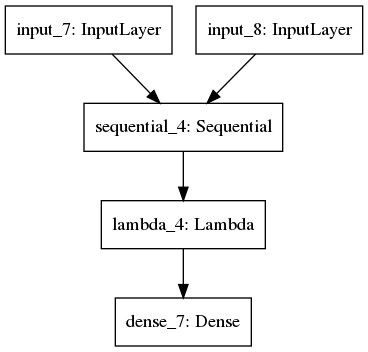

In [56]:
from keras.utils import plot_model
plot_model(siamese_model, to_file='model.png')
img = Image.open('model.png')
display(img)

In [71]:
# train the model
EPOCHS = 10
BATCH_SIZE = 1
# checkpointer = ModelCheckpoint(filepath='saved_models/weights.model_1.h5', verbose=1, save_best_only=True)
history = siamese_model.fit(
        x=tensors_train,
        y=tensors_train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        # callbacks=[checkpointer],
        validation_split=0.1,
        verbose=1)

Train on 90 samples, validate on 10 samples
Epoch 1/10
90/90 [==============================] - 60s 669ms/step - loss: 0.9723 - val_loss: 1.1203
Epoch 2/10
90/90 [==============================] - 60s 667ms/step - loss: 0.9745 - val_loss: 1.2553
Epoch 3/10
90/90 [==============================] - 60s 668ms/step - loss: 1.0534 - val_loss: 1.2958
Epoch 4/10
90/90 [==============================] - 60s 670ms/step - loss: 0.9794 - val_loss: 1.1918
Epoch 5/10
90/90 [==============================] - 60s 670ms/step - loss: 0.9870 - val_loss: 1.2004
Epoch 6/10
90/90 [==============================] - 60s 671ms/step - loss: 0.9972 - val_loss: 1.1374
Epoch 7/10
90/90 [==============================] - 60s 672ms/step - loss: 0.9817 - val_loss: 1.2298
Epoch 8/10
90/90 [==============================] - 60s 671ms/step - loss: 0.9881 - val_loss: 1.2089
Epoch 9/10
90/90 [==============================] - 60s 671ms/step - loss: 1.0079 - val_loss: 1.1795
Epoch 10/10
90/90 [============================

In [ ]:
print(df_same.head(2))
print(df_diff.head(2))

In [ ]:
# train tensors with just 4 pairs: 2 same-label and 2 diff-label
tensors_1 = np.zeros((4, 320, 480, 1))
tensors_2 = np.zeros((4, 320, 480, 1))

path = 'cropped_cleaned/train/'

tensors_1[0] = img_to_tensor(path+'0000e88ab.jpg')
tensors_1[1] = img_to_tensor(path+'0001f9222.jpg')
tensors_1[2] = img_to_tensor(path+'4cb90f820.jpg')
tensors_1[3] = img_to_tensor(path+'78f190f6c.jpg')

tensors_2[0] = img_to_tensor(path+'0af805558.jpg')
tensors_2[1] = img_to_tensor(path+'1d6ccd05a.jpg')
tensors_2[2] = img_to_tensor(path+'ffa5fa27e.jpg')
tensors_2[3] = img_to_tensor(path+'935851f78.jpg')

tensors_train = [tensors_1, tensors_2]

tensors_train_labels = np.zeros(4)
tensors_train_labels[:2] = 1

print(tensors_train_labels)
print(tensors_train)

In [59]:
print(df_same.iloc[[102,103]])
print(df_diff.iloc[[102,103]])

            Image1         Image2
102  01dcb420f.jpg  6c6895185.jpg
103  01dfca144.jpg  a221c8f14.jpg
            Image1         Image2
102  0fd6ca5c6.jpg  2243848d9.jpg
103  58fc0c7ae.jpg  bef88f48f.jpg


In [73]:
# test tensors 
tensors_1 = np.zeros((2, 320, 480, 1))
tensors_2 = np.zeros((2, 320, 480, 1))

path = 'cropped_cleaned/train/'

tensors_1[0] = img_to_tensor(path+'01dcb420f.jpg')
tensors_1[1] = img_to_tensor(path+'01dfca144.jpg')
tensors_2[0] = img_to_tensor(path+'6c6895185.jpg')
tensors_2[1] = img_to_tensor(path+'a221c8f14.jpg')

tensors_test = [tensors_1, tensors_2]

# tensors_test_labels = np.zeros(1)
# tensors_test_labels[0] = 1

In [76]:
preds = siamese_model.predict(tensors_test)
print(preds)

[[0.46363422]
 [0.59363157]]


In [ ]:
# function to convert image to tensor
def img_to_tensor(img, size=(320,480)):
    '''
    img: path to image file
    size: (height, width)
    '''
    HEIGHT, WIDTH = size
    tensor = np.zeros((HEIGHT, WIDTH))
    # load image to PIL format
    img = Image.open(img)
    # convert to numpy array/tensor with shape (HEIGHT, WIDTH, 1)
    x = image.img_to_array(img)
    # min-max normalize
    xmin   = np.min(x)
    xmax   = np.max(x)
    xrange = xmax-xmin
    x      = (x-xmin)/xrange
    return x

In [ ]:
# function to convert images to tensors
def imgs_to_tensors(df, path, size=(320,480)):
    '''
    df: dataframe listing image file names in column "Image"
    path: directory where image files are located
    size: (height, width)
    '''
    LEN = df.shape[0]
    HEIGHT, WIDTH = size
    tensors = np.zeros((LEN, HEIGHT, WIDTH))
    i = 0
    for fname in df.Image:
        fname = path + '/' + fname
        if (i%1000==0):
            print('Processing image {}: {}'.format(i, fname))
        x = img_to_tensor(fname, size)
        tensors[i] = x
        i += 1
    return tensors

In [ ]:
# function to convert images to tensors
def img_to_tensor_1(img):
    '''
    df: dataframe listing image file names in column "Image"
    path: directory where image files are located (don't include /)
    size: target height and width to resize images to
    '''
    HEIGHT = 320
    WIDTH  = 480
    tensor = np.zeros((HEIGHT, WIDTH))
    path = 'cropped_cleaned/train/'
    im_path = path + '/' + img
    # load image to PIL format
    # https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/python/keras/_impl/keras/preprocessing/image.py
    im = image.load_img(path=im_path,
                        color_mode='grayscale', 
                        target_size=(HEIGHT, WIDTH), 
                        interpolation='nearest')
    # convert to numpy array/tensor with shape (HEIGHT, WIDTH, 3)
    x = image.img_to_array(im)
    x = x/255.
    #x = preprocess_input(x) # important line! I am not sure why
    tensor = x
    return tensor

In [ ]:
# function to convert images to tensors
def img_to_tensor_2(img):
    '''
    df: dataframe listing image file names in column "Image"
    path: directory where image files are located (don't include /)
    size: target height and width to resize images to
    '''
    HEIGHT = 320
    WIDTH  = 480
    tensor = np.zeros((HEIGHT, WIDTH))
    path = 'cropped_cleaned/train/'
    im_path = path + '/' + img
    # load image to PIL format
    im = Image.open(im_path)
    # convert to numpy array/tensor with shape (HEIGHT, WIDTH, 3)
    x = image.img_to_array(im)
    x = x/255.
    #x = preprocess_input(x) # important line! I am not sure why
    tensor = x
    return tensor

In [ ]:
# function to convert images to tensors
def img_to_tensor_3(img):
    '''
    df: dataframe listing image file names in column "Image"
    path: directory where image files are located (don't include /)
    size: target height and width to resize images to
    '''
    HEIGHT = 320
    WIDTH  = 480
    tensor = np.zeros((HEIGHT, WIDTH))
    path = 'cropped_cleaned/train/'
    im_path = path + '/' + img
    # load image to PIL format
    im = Image.open(im_path)
    # convert to numpy array/tensor with shape (HEIGHT, WIDTH, 3)
    x = image.img_to_array(im)
    # min-max normalize
    xmin   = np.min(x)
    xmax   = np.max(x)
    xrange = xmax-xmin
    x      = (x-xmin)/xrange
    tensor = x
    return tensor

In [ ]:
# img = 'ba77b41f2.jpg' # high contrast
# img = 'bb664bae7.jpg' # dark
# img = 'bb5dcdfef.jpg' # dark
img = 'c80a6bdbc.jpg' # bright
# img = 'ba68eb0e1.jpg' # normal
# img = 'e36a2b17d.jpg' # black border
t2 = img_to_tensor_2(img)
img = 'cropped_cleaned/train/' + img
t3 = img_to_tensor(img, (320,480))
print('mean:{:.2f} min:{:.2f} max:{:.2f}'.format(np.mean(t2), np.min(t2), np.max(t2)))
print('mean:{:.2f} min:{:.2f} max:{:.2f}'.format(np.mean(t3), np.min(t3), np.max(t3)))

# normalize
# mn = np.min(t2)
# mx = np.max(t2)
# t3 = (t2-mn)/(mx-mn)
im_orig = image.array_to_img(t2)
im_norm = image.array_to_img(t3)
#ind = np.unravel_index(np.argmin(t2, axis=None), t2.shape)
# np.all(t1 == t2)
display(im_orig)
display(im_norm)

In [ ]:
df = pd.read_csv('cropped_cleaned/traindf.csv')
print(df.head(15))

In [ ]:
def resize_cropped_image(img_name, img_shape=(400, 400, 1)):
    """
    Function to convert all images to give shape
    img_shape = (width, height, color_channels)
    """
    p = 'cropped/train/' + img_name
    size = img_shape[:-1]
    mode = 'L' if img_shape[-1] == 1 else 'RGB'
    
    # read image and transform
    img   = Image.open(p).convert(mode)
    img   = img.resize(img_shape[:-1])

    return img

In [ ]:
p = '00029d126.jpg'
p_full = 'cropped/train/' + p
img_full   = Image.open(p_full).convert('L')
display(img_full)
img = resize_cropped_image(p, (480,320,1))
display(img)
# p = 'cropped/train/' + p
# img   = Image.open(p).convert('L')
# traindf.loc[traindf.Image==p, ['Width', 'Height']].values[0]

In [ ]:
# load train files and labels into dataframe
traindf_all = pd.read_csv('train.csv')
print(traindf_all.head())
print(len(traindf_all))

In [ ]:
# remove unlabeled images
traindf = traindf_all.drop(traindf_all[traindf_all.Id == 'new_whale'].index.tolist())
traindf.reset_index(drop=True, inplace=True)
del traindf_all
print(traindf.head())
print(len(traindf))

In [ ]:
# create dataframe with distinct ids and count of images per id
ids = pd.DataFrame(traindf['Id'].unique(), columns=['Id'])
ids['Count'] = 0
for r in ids.itertuples():
    id = r.Id
    cnt = len(traindf[traindf['Id'] == id])
    ind = ids[ids['Id'] == id].index.values[0]
    ids.loc[ind, 'Count'] = cnt
print(ids.head(3))
print(len(ids))

In [ ]:
# how many images could be used for siamese nn?
len(ids[(ids.Count>1)&(ids.Count<10)])

In [ ]:
traindf.to_csv('background_removal/traindf.csv', index=False)
ids.to_csv('background_removal/ids.csv', index=False)

In [ ]:
# Get image dimensions and color mode for all training images
traindf['Width'] = 0
traindf['Height'] = 0
traindf['Mode'] = ''
i = 0
for r in traindf.itertuples(): 
    img_name = r.Image 
    img_path = 'train/' + img_name
    img = Image.open(img_path) 
    width, height = img.size
    mode = img.mode
    traindf.loc[i, ['Width', 'Height', 'Mode']] = width, height, mode
    i += 1
print(traindf.head())

In [ ]:
# load test files into dataframe
filelist = os.listdir('test')
testdf = pd.DataFrame(filelist, columns=['Image'])
print(testdf.head())
print(len(testdf))

In [ ]:
# Get image dimensions and color mode for all testing images
testdf['Width'] = 0
testdf['Height'] = 0
testdf['Mode'] = ''
i = 0
for r in testdf.itertuples(): 
    img_name = r.Image 
    img_path = 'test/' + img_name
    img = Image.open(img_path) 
    width, height = img.size
    mode = img.mode
    testdf.loc[i, ['Width', 'Height', 'Mode']] = width, height, mode
    i += 1
print(testdf.head())

In [ ]:
# import bounding boxes
bbox = pd.read_csv('bounding_boxes.csv')
print(bbox.head())
print(len(bbox))
# expect 33,321 rows, all training and testing images

In [ ]:
x0, y0, x1, y1 = bbox[bbox.Image=='00029d126.jpg'].values.tolist()[0][1:]

In [ ]:
# crop training images
for r in traindf.itertuples():
    img_fname = r.Image
    width = r.Width
    height = r.Height
    
    # get bounding box coordinates for the image
    bb = bbox[bbox.Image==img_fname]
    # expand crop area a little bit, using this margin
    margin = 35
    x0 = max(0, bb.x0.values[0]-margin)
    y0 = max(0, bb.y0.values[0]-margin)
    x1 = min(width, bb.x1.values[0]+margin)
    y1 = min(height, bb.y1.values[0]+margin)
    w = x1-x0
    h = y1-y0
    
    img = cv2.imread('train/' + img_fname)
    img = img[y0:y1, x0:x1]
    cv2.imwrite(('cropped/train/' + img_fname), img)

In [ ]:
# crop testing images
for r in testdf.itertuples():
    img_fname = r.Image
    width = r.Width
    height = r.Height
    
    # get bounding box coordinates for the image
    bb = bbox[bbox.Image==img_fname]
    # expand crop area a little bit, using this margin
    margin = 35
    x0 = max(0, bb.x0.values[0]-margin)
    y0 = max(0, bb.y0.values[0]-margin)
    x1 = min(width, bb.x1.values[0]+margin)
    y1 = min(height, bb.y1.values[0]+margin)
    w = x1-x0
    h = y1-y0
    
    img = cv2.imread('test/' + img_fname)
    img = img[y0:y1, x0:x1]
    cv2.imwrite(('cropped/test/' + img_fname), img)

In [ ]:
# this needs improvement
# this is code to extract foreground (remove background) from images
# it works pretty good but is not reliable enough as is
i = 0
for r in traindf.itertuples():
    # run for 10 images only and check results
    i += 1
    if i > 10:
        break

    img_fname = r.Image
    width = r.Width
    height = r.Height
    
    # get bounding box coordinates for the image
    bb = bbox[bbox.Image==img_fname]
    # expand crop area by this margin
    margin = 35
    x0 = max(0, bb.x0.values[0]-margin)
    y0 = max(0, bb.y0.values[0]-margin)
    x1 = min(width, bb.x1.values[0]+margin)
    y1 = min(height, bb.y1.values[0]+margin)
    w = x1-x0
    h = y1-y0
    
    # use OpenCV's GrabCut algorithgm
    img = cv2.imread('train/' + img_fname)
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (x0,y0,w,h)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,3,cv2.GC_INIT_WITH_RECT)

    # create cropped image with background set to 0, foreground as is
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img2 = img*mask2[:,:,np.newaxis]
    img2 = img2[y0:y1, x0:x1]
    
    # create cropped image with background set to 0, foreground set to 255
    mask3 = np.where((mask==2)|(mask==0),0,255).astype('uint8')
    img3 = mask3[:,:,np.newaxis]
    img3 = img3[y0:y1, x0:x1]

    # write to disk
    cv2.imwrite(('augmented/temp0/' + img_fname), img)
    cv2.imwrite(('augmented/temp1/' + img_fname), img2)
    cv2.imwrite(('augmented/temp2/' + img_fname), img3)

In [ ]:
# create dataframe with distinct ids and count of images per id
ids = pd.DataFrame(traindf['Id'].unique(), columns=['Id'])
ids['Count'] = 0
for r in ids.itertuples():
    id = r.Id
    cnt = len(traindf[traindf['Id'] == id])
    ind = ids[ids['Id'] == id].index.values[0]
    ids.loc[ind, 'Count'] = cnt
print(ids.head(3))
print(len(ids))